<a href="https://colab.research.google.com/github/vgrinin/diploma/blob/main/%D0%94%D0%B8%D0%BF%D0%BB%D0%BE%D0%BC_3_%D1%87%D0%B0%D1%81%D1%82%D1%8C_%D1%82%D0%BE%D1%80%D0%B3%D0%BE%D0%B2%D0%BB%D1%8F_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Предсказание тренда

А что если поискать автокорреляцию, в поисках например недельных или месячных корреляций?

многое взято отсюда https://habr.com/ru/post/584896/

чтобы сэкономить код
df = pd.read_csv(PATH,		   # путь к файлу
               index_col=[0],   # столбец, который будет индексом
               parse_dates=[0]  # столбец, который надо перевести в формат даты
df.resample(‘w’).sum()                       # Пример ресемплирования данных
df.index.is_monotonic # проверка на монотонность
df['month'] = df.index.month  # можно выделить например месяц из индекса по дате  https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#time-date-components
df[‘rolling_window’] = df[‘value’].rolling(6).mean()  # так делается скользящее окно на последнююю дату окна
В большинстве задач помогает окно от 3 до 7 последовательных записей
df[‘lag_1’] = df[‘value’].shift(1)  # аргумент shift равен кол-ву шагов для сдвига

df[‘year’] = df[‘year’].apply(lambda x: 2021 – x) # минимизация значений улучшает качество работы сети

http://mathprofi.ru/assimetriya_i_excess.html
df[‘peaks’] = df[‘value’].rolling(6).apply(lambda x: len(find_peaks(x)[0]) --пики
df[‘kurtosis’] = df[‘value’].rolling(6).apply(lambda x: kurtosis(x)) -- эксцессы

может имеет смысл учитывать выходные дни и праздники, так как за проаздники может накопиться напряжения ожидания отчего выброс в понедельник будт сильнее, проверить на реальных данных
https://kaggle.com/kingoffitpredict/nta-timeseries

библиотеки для выделения признаков
https://featuretools.com/
https://tsfresh.readthedocs.io/

In [1]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras.utils import to_categorical 
import numpy as np #Numpy
from tensorflow.keras.optimizers import Adam #Оптимизатор
from tensorflow.keras.models import Sequential, Model #Два варианты моделей
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector #Стандартные слои
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator # для генерации выборки временных рядов

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

from google.colab import drive


import plotly.graph_objects as go
from plotly.offline import iplot

from plotly.subplots import make_subplots

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler # проверить все

In [2]:
drive.mount('/content/drive')
driveFolder = '/content/drive/My Drive/neuralnetwork/diploma/'
ticker = 'TGKA'
period = 'hour'  # day or hour
fileName = driveFolder + ticker + '_' + period + '.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# загрузим данные и посмотрим как они выглядят
data = pd.read_csv(fileName)
data[:15]

,time,open,high,low,close,volume
0,2018-03-07 18:00:00+00:00,0.011710,0.011710,0.011665,0.011665,107
1,2018-03-07 19:00:00+00:00,0.011670,0.011705,0.011670,0.011685,320
2,2018-03-07 20:00:00+00:00,0.011690,0.011695,0.011670,0.011680,71
3,2018-03-07 21:00:00+00:00,0.011695,0.011695,0.011670,0.011675,174
4,2018-03-07 22:00:00+00:00,0.011690,0.011695,0.011655,0.011670,798
5,2018-03-07 23:00:00+00:00,0.011670,0.011685,0.011650,0.011660,1400
6,2018-03-08 07:00:00+00:00,0.011710,0.011780,0.011710,0.011780,5929
7,2018-03-09 14:00:00+00:00,0.011770,0.011770,0.011670,0.011755,482
8,2018-03-09 15:00:00+00:00,0.011715,0.011730,0.011670,0.011700,1703
9,2018-03-09 16:00:00+00:00,0.011700,0.011720,0.011700,0.011715,193


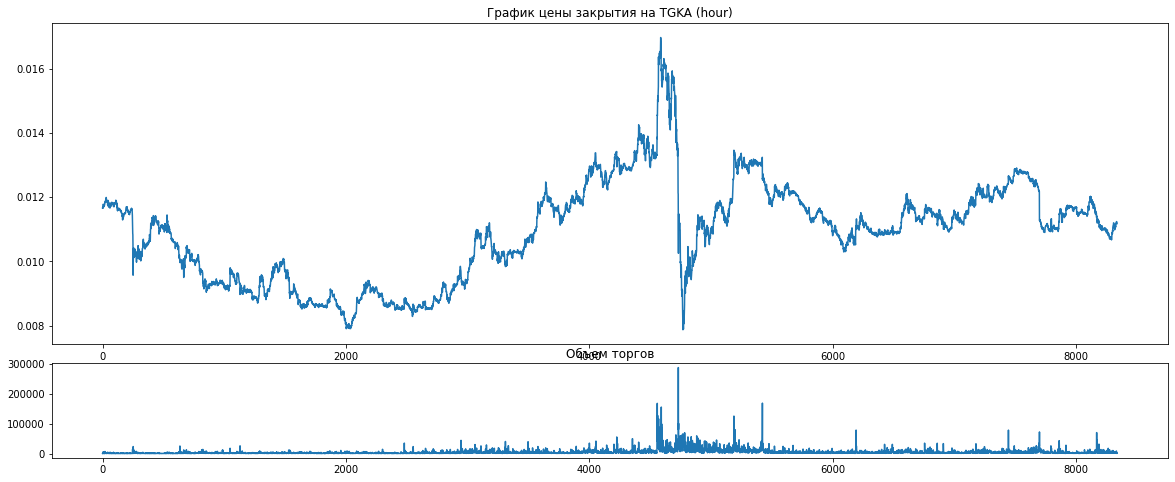

In [4]:
# Построим график цены закрытия и объема торгов
plt.figure(figsize=(20,8))
ax0 = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
ax1 = plt.subplot2grid((4,4), (3, 0), rowspan=1, colspan=4)
data['close'].plot(ax = ax0, title = 'График цены закрытия на '+ ticker + ' (' + period + ')')
data['volume'].plot(ax = ax1, title = 'Объем торгов')
plt.show()

In [5]:
step_in_the_last = 14     # По скольки шагам в прошлое определяем тренд     ##20,16,16,4
n_steps = 19              # Серию из скольки баров анализируем         ##44,42,48,6  - необходимо найти оптимальный
forward_lag = 1           # Предсказание какого бара в будущем делаем       ##1

In [6]:
# оставляем только OHLCV (убираем время, чтобы не мешало)
df_data = data[['open','low','high','close','volume']]

In [7]:
# считаем относительную доходность по цене close на step_in_the_last шагов назад
for i in range(step_in_the_last):
  indicator_name = 'close_chng_%d' % (i+1)
  df_data[indicator_name] = df_data['close'].pct_change(i+1) # относительная доходность

# посмотрим, что получилось
df_data.head()

,open,low,high,close,volume,close_chng_1,close_chng_2,close_chng_3,close_chng_4,close_chng_5,close_chng_6,close_chng_7,close_chng_8,close_chng_9,close_chng_10,close_chng_11,close_chng_12,close_chng_13,close_chng_14
0,0.011710,0.011665,0.011710,0.011665,107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.011670,0.011670,0.011705,0.011685,320,0.001715,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.011690,0.011670,0.011695,0.011680,71,-0.000428,0.001286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.011695,0.011670,0.011695,0.011675,174,-0.000428,-0.000856,0.000857,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.011690,0.011655,0.011695,0.011670,798,-0.000428,-0.000856,-0.001284,0.000429,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# удалим недозаполненные строчки
df_data = df_data.dropna() # удаляем строки с NaN
df_data.head()
# индексация начинается с 14 - потерял первые 14 отсчетов (с 0 по 13), 
# так как для них не были вычислены все step_in_the_last показателей close_chng

,open,low,high,close,volume,close_chng_1,close_chng_2,close_chng_3,close_chng_4,close_chng_5,close_chng_6,close_chng_7,close_chng_8,close_chng_9,close_chng_10,close_chng_11,close_chng_12,close_chng_13,close_chng_14
14,0.011730,0.011725,0.011760,0.011760,242,0.002985,0.004699,0.004699,0.004270,0.003841,0.005128,0.000425,-0.001698,0.008576,0.007712,0.007281,0.006849,0.006418,0.008144
15,0.011755,0.011740,0.011755,0.011740,6,-0.001701,0.001279,0.002990,0.002990,0.002562,0.002134,0.003419,-0.001276,-0.003396,0.006861,0.005998,0.005567,0.005137,0.004707
16,0.011745,0.011745,0.011750,0.011750,3,0.000852,-0.000850,0.002132,0.003845,0.003845,0.003416,0.002988,0.004274,-0.000425,-0.002547,0.007719,0.006855,0.006424,0.005993
17,0.011760,0.011760,0.011785,0.011765,708,0.001277,0.002129,0.000425,0.003412,0.005126,0.005126,0.004697,0.004268,0.005556,0.000851,-0.001273,0.009005,0.008141,0.007709
18,0.011805,0.011805,0.011805,0.011805,100,0.003400,0.004681,0.005537,0.003827,0.006823,0.008543,0.008543,0.008113,0.007682,0.008974,0.004254,0.002122,0.012436,0.011568


Здесь, например close_chng_14 для 14 строчки показывает относительное изменение цены в 14 строчке относительно цены в 0-й строчке, т.е.:

close_chng_14[14]=(close[14]-close[0])/close[0]

Или более общая формула:

close_chng_N[i]=(close[i]-close[i-N])/close[i-N]

Проверим: 
close_chng_3[15]=(close[15]-close[12])/close[12]

0.002990 = (0.011740-0.011705)/0.011705 (верно!)

In [9]:
# Определим направление тренда
# 0 - нейтральное изменения тренда
# 1 - ход тренда вверх
# 2 - ход тренда вниз
hold_signal_value=0
up_signal_value=1
down_signal_value=2

# Относительное изменение цены (close_chng_X) будут сравниваться с пороговым 
# (его можно подобрать оптимально при отладке нейросетки)
# Изменение по модулю меньше этого значения будут считаться нейтральным трендом, 
# изменение ниже чем (-delta_trend) - нисходящим трендом, 
# изменение выше чем (+delta_trend) - восходящим трендом
delta_trend=0.005 

for i in range(step_in_the_last):
  indicator_name = 'close_chng_%d' % (i+1)
  indicator_name_new = 'Y_%d' % (i+1)
  df_data[indicator_name_new] = hold_signal_value
  df_data.loc[df_data[indicator_name] >= delta_trend , indicator_name_new] = up_signal_value
  df_data.loc[df_data[indicator_name] <= -delta_trend , indicator_name_new] = down_signal_value

# удалим ставшие ненужными колонки с относительной доходностью
for i in range(step_in_the_last):
  indicator_name = 'close_chng_%d' % (i+1)
  del df_data[indicator_name]

Однако стоит также попробовать сетку в которой в качестве направления тренда используется не (0,1,2) а все таки исходные close_chng_X

In [10]:
df_data[:10]

,open,low,high,close,volume,Y_1,Y_2,Y_3,Y_4,Y_5,Y_6,Y_7,Y_8,Y_9,Y_10,Y_11,Y_12,Y_13,Y_14
14,0.011730,0.011725,0.011760,0.011760,242,0,0,0,0,0,1,0,0,1,1,1,1,1,1
15,0.011755,0.011740,0.011755,0.011740,6,0,0,0,0,0,0,0,0,0,1,1,1,1,0
16,0.011745,0.011745,0.011750,0.011750,3,0,0,0,0,0,0,0,0,0,0,1,1,1,1
17,0.011760,0.011760,0.011785,0.011765,708,0,0,0,0,1,1,0,0,1,0,0,1,1,1
18,0.011805,0.011805,0.011805,0.011805,100,0,0,1,0,1,1,1,1,1,1,0,0,1,1
19,0.011805,0.011775,0.011945,0.011840,4227,0,1,1,1,1,1,1,1,1,1,1,1,1,1
20,0.011845,0.011810,0.011910,0.011835,6614,0,0,1,1,1,1,1,1,1,1,1,1,1,0
21,0.011840,0.011810,0.011865,0.011845,2799,0,0,0,1,1,1,1,1,1,1,1,1,1,1
22,0.011845,0.011805,0.011880,0.011850,1346,0,0,0,0,1,1,1,1,1,1,1,1,1,1
23,0.011870,0.011815,0.011870,0.011835,1525,0,0,0,0,0,1,1,1,1,1,1,1,1,1


In [11]:
print(df_data.shape)
# размерность 19 = сумме 5 характеристик торгов (OHLCV) и 14 вычисленных показателей тренда

(8325, 19)


In [12]:
#формируем yTrain
indicator_name = 'Y_%d' % forward_lag
data_Y = df_data[indicator_name]

data_Y.head()

14    0
15    0
16    0
17    0
18    0
Name: Y_1, dtype: int64

In [13]:
Y_ohe = to_categorical(data_Y, num_classes = 3)
print(Y_ohe[:5])

[[1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]
 [1. 0. 0.]]


In [14]:
# берем для xTest последние 10 процентов от всего графика цены
n_test = len(df_data)//10
xTrain_ = df_data[:-n_test-n_steps]
xTest_ = df_data[-n_test:]
yTrain_ = Y_ohe[:-n_test-n_steps]
yTest_ = Y_ohe[-n_test:]

print('xTrain: ', xTrain_.shape, '\tyTrain:', yTrain_.shape,
      '\nxTest:  ', xTest_.shape, '\tyTest: ', yTest_.shape)
xTrain_.shape[0]+xTest_.shape[0]

xTrain:  (7474, 19) 	yTrain: (7474, 3) 
xTest:   (832, 19) 	yTest:  (832, 3)


8306

In [15]:
# Масштабируем X при помощи RobustScaler чтобы избавиться от выбросов
xScaler = RobustScaler()
xScaler.fit(xTrain_, yTrain_)
xTrain = xScaler.transform(xTrain_)
xTest = xScaler.transform(xTest_)

In [16]:
def split_sequences(x, y, n_steps):
  gen = TimeseriesGenerator(
      x, y,
      length=n_steps,
      sampling_rate=1, stride=1,
      batch_size=1
      )

  x_ = []
  y_ = []
  for i, g in enumerate(gen):
    x_.append(g[0])  
    y_.append(g[1])

  # переводим из типа list в ndarray
  x_ = np.concatenate(x_)
  y_ = np.concatenate(y_)
  return (x_, y_)

In [17]:
# Формируем выборки для обучения
xTrain, yTrain = split_sequences(xTrain, yTrain_, n_steps)

# Формируем выборки для валидации
xTest, yTest = split_sequences(xTest, yTest_, n_steps)

In [18]:
print('xTrain', xTrain.shape, '=>', 'yTrain', yTrain.shape)
print('xTest', xTest.shape, '=>', 'yTest', yTest.shape)

xTrain (7455, 19, 19) => yTrain (7455, 3)
xTest (813, 19, 19) => yTest (813, 3)


In [19]:
# определяет текущую сделку и состояние алгоритма по предикту сетки
def get_deal(i, prediction, state):

  if i==0: #на первом шаге ничего не делаем
    return hold_signal_value, hold_signal_value

  # при нулевом тренде просто держим позицию, какой она ни была до этого
  if prediction == hold_signal_value:
    return state, hold_signal_value

  # если пришел сигнал на снижающийся тренд
  if prediction == down_signal_value and prediction != state:
    # то продаем
    return down_signal_value, down_signal_value

  # если пришел сигнал на растущий тренд
  if prediction == up_signal_value and prediction != state:
    # то покупаем
    return up_signal_value, up_signal_value

  # этот блок сработает если предсказан тренд, который ранее начал осблуживаться сеткой
  return state, hold_signal_value

In [20]:
def count_deals(deals):
  # Посчитаем предсказанные ненулевые сделки (тренды)
  nonnul_deals = 0
  ret = []
  for i, d in enumerate(deals):
    if d > 0:
      nonnul_deals+=1
      ret.append([i, d])
  print('Всего', nonnul_deals, 'сделок')
  return np.array(ret)

In [55]:
def calc_cheats(yTest):
  # цикл для формирования сделок по реальным значениям, читерский, как если бы мы могли заглянуть в будущее
  nonnul_answer=0
  state = 0

  # учитываем, что 0-й элемент yTest показывает тренд на шаге n_steps
  # а применять сделку по нему надо на шаг назад = (n_steps-1)
  # т.е. при торговле находясь на 18 шаге мы берем для предсказания
  # отсчеты с индексами [0..18] и "угадав" тренд который будет далее (на 19 шаге)
  # совершаем сделку
  cheats = [0] * (n_steps-1)  # когда купить (1), когда продать (-1), когда держать(0)
  for i in range(len(yTest)-n_steps):
    prediction = np.argmax(yTest[i])

    if prediction != hold_signal_value:
      nonnul_answer+=1

    state, deal = get_deal(i, prediction, state)
    cheats.append(deal)

  print('Ненулевых ответов:', nonnul_answer)
  cheats_scatter = count_deals(cheats)
  print(cheats_scatter[:5])
  return cheats_scatter, cheats

In [22]:
def plot_deals(prices, deals, title):

  pr = go.Line(x=np.arange(0, len(prices), 1), 
               y=prices)
  
  dl = go.Scatter(
      mode='markers',
      x=deals[:,0], 
      y=prices[deals[:,0]], 
      marker_symbol=['triangle-down' if deals[i,1]==down_signal_value else 'triangle-up' for i in range(len(deals))],
      marker_color=['red' if deals[i,1]==down_signal_value else 'green' for i in range(len(deals))], 
      marker_size=12
      )

  data = [pr, dl]
  figure = dict(data=data)
  iplot(figure)

In [56]:
cheats_scatter, cheats = calc_cheats(yTest)

Ненулевых ответов: 110
Всего 55 сделок
[[ 20   2]
 [ 21   1]
 [ 40   2]
 [120   1]
 [121   2]]


In [ ]:
#xTest - 1-й индекс - номер батча, 2-й индекс - номер элемента внутри батча, 3-1 - индекс характристики (OHLCV и т .д)
tradeXTest = xScaler.inverse_transform(xTest[:,0,:])
prices = tradeXTest[:,3]

In [57]:
plot_deals(prices, cheats_scatter, 'Читерские сделки от оракула')

/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




In [58]:
def test_deals(tradeXTest, deals, money):
  # стартовый капитал
  ms = []
  stocks = 0.0
  for i in range(0, tradeXTest.shape[0], 1):
    if money==0:
      ms.append(ms[-1])
    else:
      ms.append(money)
    if deals[i]==up_signal_value and stocks==0:
      stocks = money / tradeXTest[i, 3]
      money = 0
      continue
    if deals[i]==down_signal_value and stocks>0:
      money = stocks * tradeXTest[i, 3]
      stocks = 0
      continue
  if stocks>0:
    money = stocks * tradeXTest[i, 3]
    stocks = 0
  return money, stocks, ms

In [63]:
# проведем тестовую торговлю на читах
cheats2 = np.zeros(xTest.shape[0])
for i in range(len(cheats2)):
  for k in range(cheats_scatter.shape[0]):
    if i==cheats_scatter[k,0]:
      cheats2[i]=cheats_scatter[k,1]
  
money, stocks, ms2 = test_deals(tradeXTest, cheats2, 100000.0)
print(money)
print(stocks)

149983.16030547497
0


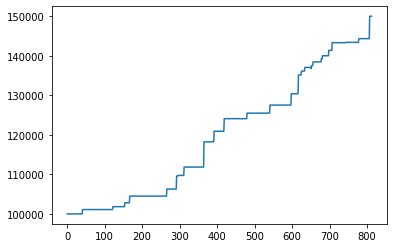

In [64]:
# Построим график капитала на читах
plt.plot(ms2)
plt.show()

In [65]:
# -----------------------------
# Conv1D = создаем модель
# -----------------------------

# xTrain.shape[1] - число шагов назад для обучения
# xTrain.shape[2] - число столбцов в обучающей выборке
  
drop = 0.4
input = Input(shape=(xTest.shape[1], xTest.shape[2]))
x = Flatten()(input)
x = RepeatVector(4)(x)
x = Conv1D(n_steps*2, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = RepeatVector(4)(x)
x = Conv1D(n_steps, 5, padding='same', activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(n_steps*100, activation='relu')(x)
x = Dropout(drop)(x)
x = Dense(yTrain.shape[1], activation='sigmoid')(x)
model = Model(input, x)


In [29]:
def train_nn(model, epochs, verbose):
  model.compile(optimizer=Adam(learning_rate = 5e-05),
                loss='categorical_crossentropy',
                metrics=['accuracy']) 

  # fit model
  history = model.fit(xTrain, yTrain, epochs=epochs, verbose = verbose,
                      validation_data=(xTest, yTest))

  plt.figure(figsize=(6,4))
  plt.plot(history.history['accuracy'], label='accuracy')
  plt.plot(history.history['val_accuracy'], label='val_accuracy')
  plt.legend()
  plt.show()
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.show()

In [61]:
def calc_deals(model, xTest, yTest):
  # цикл для распознавания всех тестовых вариантов и вывода класса
  true_answer = 0
  true_nonnul_answer=0
  nonnul_answer=0
  true_nonnul_moves=0
  nonnul_moves=0
  state = 0
  predictions = [] # само предсказание 

  # учитываем, что 0-й элемент yTest показывает тренд на шаге n_steps
  # а применять сделку по нему надо на шаг назад = (n_steps-1)
  # т.е. при торговле находясь на 18 шаге мы берем для предсказания
  # отсчеты с индексами [0..18] и "угадав" тренд который будет далее (на 19 шаге)
  # совершаем сделку
  deals = [0] * (n_steps-1) # когда купить (1), когда продать (-1), когда держать(0)
  for i in range(len(xTest)-n_steps):
    x = xTest[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x)
    prediction = np.argmax(prediction)
    predictions.append(prediction)

    if prediction == np.argmax(yTest[i]):
      true_answer+=1

    if prediction != hold_signal_value:
      nonnul_answer+=1
      if prediction == np.argmax(yTest[i]):
        true_nonnul_answer+=1

    if np.argmax(yTest[i]) != hold_signal_value:
      nonnul_moves+=1
      if prediction == np.argmax(yTest[i]):
        true_nonnul_moves+=1

    state, deal = get_deal(i, prediction, state)
    deals.append(deal)

  print('Правильных ответов: {:.2f} %'.format(true_answer*100/len(xTest)))
  print('Случаи, когда сетка предсказывала наклонный тренд и угадала: {:.2f}% = {:} / {:}'.format(true_nonnul_answer*100/nonnul_answer, true_nonnul_answer, nonnul_answer))
  print('Случаи, когда сетка угадала реальный наклонный тренд: {:.2f}% = {:} / {:}'.format(true_nonnul_moves*100/nonnul_moves, true_nonnul_moves, nonnul_moves))
  deals_scatter = count_deals(deals)
  print(deals_scatter[:5])
  return deals_scatter, deals

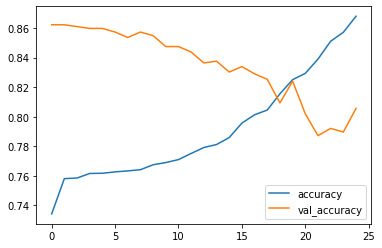

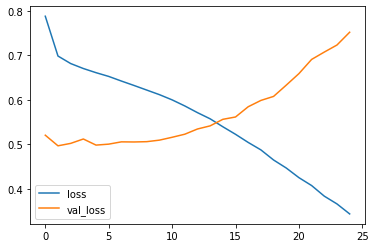

Правильных ответов: 80.57 %
Случаи, когда сетка предсказывала наклонный тренд и угадала: 5.17% = 3 / 58
Случаи, когда сетка угадала реальный наклонный тренд: 2.68% = 3 / 112
Всего 31 сделок
[[  2   1]
 [  3   2]
 [ 92   1]
 [106   2]
 [169   1]]


In [31]:
train_nn(model_conv1, 25, 0)

In [62]:
deals_scatter, deals = calc_deals(model_conv1, xTest, yTest)

Правильных ответов: 78.60 %
Случаи, когда сетка предсказывала наклонный тренд и угадала: 5.26% = 3 / 57
Случаи, когда сетка угадала реальный наклонный тренд: 2.73% = 3 / 110
Всего 31 сделок
[[ 20   1]
 [ 21   2]
 [110   1]
 [124   2]
 [187   1]]


In [66]:
# проведем тестовую торговлю на полученных результатах от сетки
plot_deals(prices, deals_scatter, 'Торговля на сетке')

# проведем тестовую торговлю на читах
deals2 = np.zeros(xTest.shape[0])
for i in range(len(deals2)):
  for k in range(deals_scatter.shape[0]):
    if i==deals_scatter[k,0]:
      deals2[i]=deals_scatter[k,1]
  
money, stocks, ms1 = test_deals(tradeXTest, deals2, 100000.0)
print(money)
print(stocks)




/usr/local/lib/python3.7/dist-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




101670.58302867408
0


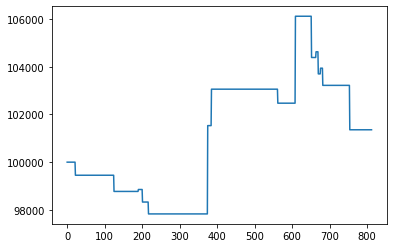

In [67]:
# Построим график капитала на предсказаниях сетки
plt.plot(ms1)
plt.show()

Ужасная торговля. За два года заработал 1670 рублей сверх 100 тысяч капитала. Сетка плохо предсказывает тренды. Лучше всего у нее получается предсказывать нудевой тренд, но толку в этом нет. Надо экспериментировать. И разобраться как работает торгующая функция из терры, там где-то ошибка, и она отдает слишком хорошие результаты при плохой игре

Сравни графики сделаок на терре и мой. Обрати внимание что на моем во второй половине графика очень много мусорных сделок, а у терры их нет. Пойми почему так? Ведь сетка одна и та же и вход у нее один и тот же. Может терра что-то сглаживает???

#Попробуем код из терры

In [34]:
# функция проверки нейросети, торгует нейросетью на деньги
# Model: вход - 
def trading(model, x_test, xScaler):
  returns = pd.DataFrame()
  statement = 0 #  {0:держим кэш, 1:в длинной позиции, 2:в короткой позиции}
  stock = 0.   # Число акций на руках
  cash = 100000.   # Стартовая сумма капитала

  # inv_capital - вероятно, кол-во денег в акциях, на момент покупки
  # -----------------------------------------

  for i in range(len(x_test)):   # Выбираю пример
    x = x_test[i]
    x = np.expand_dims(x, axis=0)
    prediction = model.predict(x) # Распознаём наш пример  == {0:stay, 1:up, 2:down}
    signal = np.argmax(prediction) # Получаем индекс самого большого элемента (это итоговая цифра)
    close = xScaler.inverse_transform(x_test[i])[-3][0] # опрелеяем текущую цену, подаваемую в нейронку

    if statement == 0  and  signal == 1:## если мы в кэше и цена будет расти то 
      statement = 1 # идем в длинную позицию (то есть покупаем, чтобы потом продать)
      capital = cash//close * close + cash - cash//close * close  # ЭТО ЧТО ЗА БРЕД??????
      # TODO формула выше сокращается до capital = cash
      
      inv_capital = cash//close * close # сколько денег потратили на покупку акций

      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close],'stock':[cash//close],  'deal_prise':[close],
                            'long':[close*0.9], 'short':[0],
                          'inv_capital':[inv_capital], 'cash':[cash - cash//close * close],
                          'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 0  and  signal == 2: ## если мы в кэше и цена будет падать то
      statement = 2 # идем в короткую поззицию (то есть продаем, чтобы потом купить - здесь будет комиссия брокера за интрадэй)
      stock = -(cash//close)  # имеем отрицательное кол-во акций
      inv_capital = -close*stock  # деньги в акциях все равно положительные

      line = pd.DataFrame({'statement':[0], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                            'long':[0], 'short':[close*1.1],
                          'inv_capital':[inv_capital],  'cash':[cash - inv_capital], 
                          'capital':[cash], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 0  and  signal == 0:## если мы в кэше, и явного сигнала нет, то ничего не делаем
      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close],'stock':[0],  'deal_prise':[0],
                            'long':[0], 'short':[0],
                          'inv_capital':[0], 'cash':[cash],
                          'capital':[cash], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 2  and  signal == 1: ## если мы в короткой позиции, и цена будет расти
      statement = 1 # TODO понять это - переходим в длинную позицию что-ли? это как?
      ret = (close-returns.iloc[i-1][4])*stock # ret - сколько денег получим с закрытия позиции, 
      # умножаем кол-во акций на разницу между текущей ценой и ценой последней сделки (то есть ценой открытия шорт-позиции)
      # помним что у нас отрицательное кол-во акций, разность цен в хорошем случае тоже отрицательная
      capital = -stock*returns.iloc[i-1][4] + returns.iloc[i-1][6] + ret
      stock = capital//close
      inv_capital = close*stock
      cash = capital - inv_capital

      line = pd.DataFrame({'statement':[2], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                            'long':[close*0.9], 'short':[0],
                          'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 2  and  signal == 2: ## если мы в короткой позиции, и цена будет падать
      # то не нужно ничего делать
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][6] # проверь это вычисление, оно странное, почему в 6-й позиции массива - КЭШ,
      inv_capital = -stock*returns.iloc[i-1][4] + (close - returns.iloc[i-1][4])*stock
      capital = inv_capital + cash

      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                            'long':[0], 'short':[0],
                          'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 2  and  signal == 0: ## ## если мы в короткой позиции, и нет сигнала
      # ничего не делаем
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][6]
      inv_capital = -stock*returns.iloc[i-1][4] + (close - returns.iloc[i-1][4])*stock
      capital = inv_capital + cash

      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                            'long':[0], 'short':[0],
                            'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 1  and  signal == 1:## если мы в длинной позиции и сигнал на рост
      # то по идее ничего не надо делать, ждать сигнала
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][6]
      inv_capital = close*stock
      capital = close*stock+cash

      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                            'long':[0], 'short':[0],
                            'inv_capital':[inv_capital], 'cash':[cash],  'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue

    elif statement == 1  and  signal == 2:## если мы в длинной позиции и сигнал на падение цены
      statement = 2 # это открытие короткой позиции что-ли?
      stock = returns.iloc[i-1][3]
      ret = (close - returns.iloc[i-1][4]) * stock
      capital = close * stock + returns.iloc[i-1][6]
      stock = -capital//close
      inv_capital = -close*stock
      cash = capital - inv_capital

      line = pd.DataFrame({'statement':[1], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[close],
                            'long':[0], 'short':[close*1.1],
                            'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[ret] })
      returns = returns.append(line, ignore_index=True)
      continue
      
    elif statement == 1  and  signal == 0:## если мы в длинной позиции и сигнала нет
      # по идее ничего делать не надо, ждать сигнала
      stock = returns.iloc[i-1][3]
      cash = returns.iloc[i-1][6]
      inv_capital = close*stock
      capital = close*stock+cash

      line = pd.DataFrame({'statement':[statement], 'signal':[signal], 'close':[close], 'stock':[stock], 'deal_prise':[returns.iloc[i-1][4]],
                            'long':[0], 'short':[0],
                            'inv_capital':[inv_capital], 'cash':[cash], 'capital':[capital], 'ret(i)':[0] })
      returns = returns.append(line, ignore_index=True)
      continue
  start = 100000 
  print('Стартовый капитал:', start)
  print('Прирост после торгов: +', int(capital) - start)
  print('Итого:', int(capital))
  return returns
  

In [35]:
def trading_all(model, x_test, xScaler):
    returns = trading(model, x_test, xScaler).copy()
    short = returns['short'].values
    short = short.astype(bool)
    long = returns['long'].values
    long = long.astype(bool)
    idx_long = np.where(long) 
    idx_short = np.where(short)
    show_long_short(returns, idx_long, idx_short)
    show_capital(returns)

In [36]:
def show_long_short(returns, idx_long, idx_short):
    plt.figure(figsize=(24,12)) 
    plt.plot(returns['close'], alpha=0.6)
    l = np.array(idx_long)[np.array(idx_long) < 600]
    s = np.array(idx_short)[np.array(idx_short) < 600]
    plt.plot(l, returns['close'].values[[l]], '^', c='g')
    plt.plot(s, returns['close'].values[[s]], 'v', c='r')    
    plt.show()    

def show_capital(returns):
  plt.figure(figsize=(24,8))
  plt.plot(returns['capital'])
  plt.show()

Стартовый капитал: 100000
Прирост после торгов: + 8502
Итого: 108502


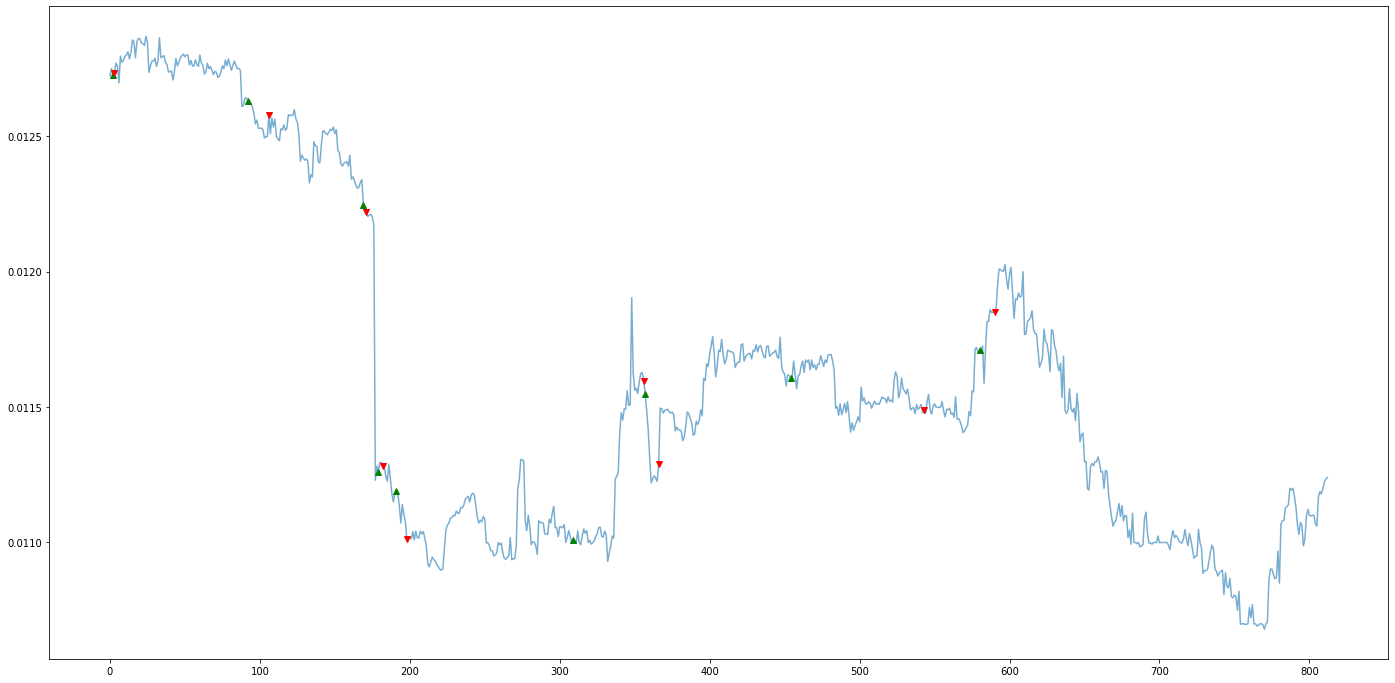

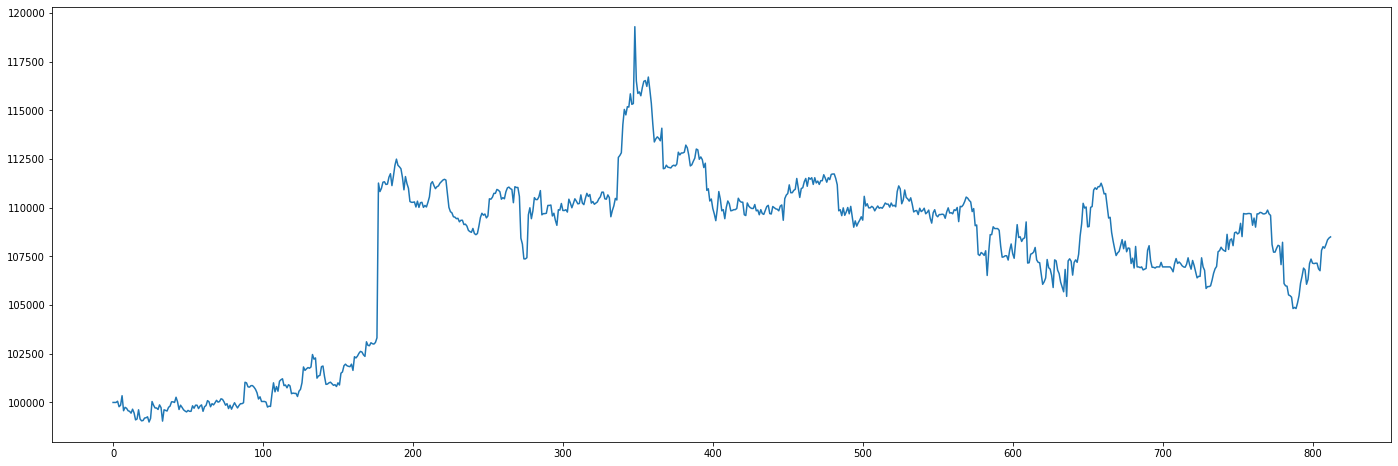

In [68]:
trading_all(model_conv1, xTest, xScaler)

Нужно проверить свою модель на торгующей функции из терры

ниже представлены отсчеты на которых я бы хотел отыгрывать покупку/продажу
* 7538-7539 0.012850-0.012790=0.0046
* 7527-7528 0.012770-0.012700=0.0055
* 7528-7529 0.012700-0.012796=0.0075
* 7547-7548 0.012840-0.012750=0.0070

будем отыгрывать все что выше 0,005


нет даже вот такие:
* 7663	2021-06-25 15:00:00+00:00	0.012322
* 7664	2021-06-28 07:00:00+00:00	0.012522
это 0,015 т.е 1,5%

а вообще надо подбирать этот порог, вот и весь сказ. чем выше порог тем реже сделаки, но крупнее выигрыши на каждую. чем ниже порог тем больше сделок, то меньше выигрыш на каждой (также больше комиссия). надо стремиться к редким но метким сделкам


1,5% это при капитале 100 000 выигрыш 1,5 тыс, в принципе нормально.